In [1]:
#Load all required packages
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.correlation import plot_corr
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,make_scorer

In [2]:
# load training data and test data
train_df = pd.read_csv('Train_Zindi.csv', index_col = 0)
test_df = pd.read_csv('Test_Zindi.csv', index_col = 0)
riders_df = pd.read_csv('Riders_Zindi.csv', index_col = 0)
sub_sample_df = pd.read_csv('SampleSubmission_Zindi.csv',index_col = 0)

In [3]:
#Join train_df with riders dataframe
# train_df = pd.merge(train_df,riders_df,how='left',on=['Rider Id','Rider Id'])

In [4]:
#Function to convert time rows to seconds after midnight
def time_fn(row):
    b = row.split(' ')
    if b[1] == 'AM':
        c = 0
    else:
        c = 12
    b = b[0].split(':')
    b = [int(i) for i in b]
    if b[0] == 12:
        c -= 12
    # convertion to minutes
    b[0] = (b[0] + c)*60*60
    b[1] = (b[1])*60
    row = sum(b)
    return(row)
#Function for column time conversion:
def time_change(df):
    time_columns = [
                'Placement - Time',\
                'Confirmation - Time',\
                'Arrival at Pickup - Time',\
                'Pickup - Time',\
                'Arrival at Destination - Time',\
               ]
    for i in df.columns:
        if i in time_columns:
            if df[i].dtype not in ['int', 'int8','int16','int64']:
                df[i] = df[i].apply(lambda x: time_fn(x))
            else:
                pass
    return(df)

In [5]:
#apply time_change on dataframe
train_df_1 = time_change(train_df)

In [6]:
# Remove rows where placement_day != confirmation day and pickup_day
train_df_1 = train_df.drop(train_df[(train_df['Placement - Day of Month'] !=\
                                   train_df['Confirmation - Day of Month'])|\
                                  (train_df['Confirmation - Day of Month'] !=\
                                   train_df['Arrival at Destination - Day of Month'])].index)

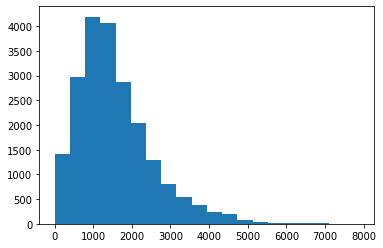

In [7]:
#Histogram of the distribution of the response
plt.hist(train_df_1['Time from Pickup to Arrival'],bins = 20)
plt.show()

In [8]:
#Based on histogram above the outliers can be removed(...so far they were chosen abitrarily)
train_df_1 = train_df_1[(train_df_1['Distance (KM)']*3600.0/train_df_1['Time from Pickup to Arrival']) < 60]

In [ ]:
#Based on histogram above the outliers can be removed(...so far they were chosen abitrarily)
# train_df_1 = train_df_1.drop(train_df_1[train_df_1['Time from Pickup to Arrival'] < 500].index)
# train_df_1 = train_df_1.drop(train_df_1[train_df_1['Time from Pickup to Arrival'] > 5000].index)

In [9]:
# Impute Null Temperature values with average temperature       
def imputer_fun(df):
    imputing_cols = ['Temperature','Precipitation in millimeters']
    imputer_avg = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    imputer_zero = SimpleImputer(missing_values = np.nan, strategy = 'constant',fill_value = 0)
    for feat in imputing_cols:
        if feat in df.columns:
            if feat == 'Temperature':
                df.loc[:,[feat]] = imputer_avg.fit_transform(df.loc[:,[feat]])
            if feat == 'Precipitation in millimeters':
                df.loc[:,[feat]] = imputer_zero.fit_transform(df.loc[:,[feat]])
    return(df)
train_df_1 = imputer_fun(train_df_1)

In [12]:
# Choose model_features and model target(Note 'Arrival at destination is dropped')
Features = ['Platform Type',\
            'Personal or Business',\
            'Placement - Day of Month',\
            'Placement - Weekday (Mo = 1)',\
#             'Placement - Time',\
#             'Confirmation - Time',\
#             'Arrival at Pickup - Time',\
            'Pickup - Time',\
            'Distance (KM)',\
            'Temperature',\
            'Precipitation in millimeters',\
#             'No_Of_Orders',\
#             'Age',\
#             'Average_Rating',\
#             'No_of_Ratings'
           ]
X = train_df_1[Features]
Y = train_df_1['Time from Pickup to Arrival']

In [13]:
# One-Hot Encode nominal categories
categorical_columns = ['Platform Type','Personal or Business','Placement - Weekday (Mo = 1)','Placement - Day of Month']
OH_X = pd.get_dummies(X,columns = categorical_columns)

In [ ]:
# # Check for linearity
# fig, axs = plt.subplots(17,3, figsize=(14,40),)
# fig.subplots_adjust(hspace = 0.5, wspace=.2)
# axs = axs.ravel()

# for index, column in enumerate(OH_X.columns):
#     axs[index].set_title("{} vs. Ar at dest".format(column),fontsize=8)
#     axs[index].scatter(x=OH_X[column],y=Y,c='blue',edgecolor='k')

In [ ]:
import seaborn as sns
corr = X.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
)
plt.show()

In [ ]:
# Feature Scaling (Feature scale numeric data on training set)
# def Feature_scaler (df):
#     from sklearn.preprocessing import StandardScaler
#     sc = StandardScaler()
#     numeric = []
#     for col in df.columns:
#         if col not in categorical_columns:
#             print(col)
# #     df[numeric] = sc.fit_transform(df[numeric_columns])

# Feature_scaler(train_df)
# # X_test = Feature_scaler(X_test)

In [14]:
# Import Linear REGRESSION MODEL
from sklearn.linear_model import LinearRegression
LM_model = LinearRegression()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [16]:
#Import Random Forest regression model
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 50,max_depth = 10)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [17]:
#Import Gradient Booster
from xgboost import XGBRegressor
XGB = XGBRegressor(n_estimators=100, learning_rate=0.1, n_jobs=4)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [18]:
#Import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth=5)

In [19]:
# Cross validation to test model accuracy
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
models = {'Linear_Model': LM_model,\
         'Random Forest Tree': rfr,\
         'Gradient Boost': XGB,\
         'Desicion_Tree': dtr
         }
rmse_scorer = make_scorer(mean_squared_error)
for name,model in models.items():
    cv = np.sqrt(cross_val_score(estimator = model,X =OH_X, y = Y, cv = 10, scoring = rmse_scorer))
    cv = cv.mean()
    print(str(name)+' RMSE: ' + str(cv))

Linear_Model RMSE: 759.5968794194137
Random Forest Tree RMSE: 763.4780725192797
Gradient Boost RMSE: 763.1821247237881
Desicion_Tree RMSE: 761.9009736037274


In [20]:
for name,model in models.items():
    model.fit(OH_X,Y)
    cv = math.sqrt(mean_squared_error(model.predict(OH_X),Y))
    print(str(name)+' RMSE: ' + str(cv))

Linear_Model RMSE: 758.5343410238193
Random Forest Tree RMSE: 679.6335201016456
Gradient Boost RMSE: 703.5278758905126
Desicion_Tree RMSE: 754.5058287287507


In [ ]:
X_sub = test_df[Features].copy()
X_sub = time_change(X_sub)

# Impute Null Temperature values with average temperature
imputing_col = ['Temperature','Precipitation in millimeters']
imputer_avg = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imputer_zero = SimpleImputer(missing_values = np.nan, strategy = 'constant',fill_value = 0)
for col in imputing_col:
    if col == 'Temperature':
        X_sub[col] = imputer_avg.fit_transform(X_sub.loc[:,[col]])
    else:
        X_sub[col] = imputer_zero.fit_transform(X_sub.loc[:,[col]])
OH_X_sub = pd.get_dummies(X_sub,columns = categorical_columns)
OH_X_sub[numeric_columns] = sc.fit_transform(OH_X_sub[numeric_columns])

In [ ]:
output = pd.DataFrame({'Time from Pickup to Arrival': LM_model.predict(OH_X_sub)},index = test_df.index)

In [ ]:
output

In [ ]:
output.to_csv('test1.csv')

In [ ]:
from pandas.api.types import is_numeric_dtype
for i in train_df.columns:
    print (is_numeric_dtype(train_df[i]))